In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64

# Data Preparation

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BIMFJV_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BIMFJV_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.BIMFJV_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [6]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [8]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [9]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [10]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [12]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [15]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [16]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

# Modeling

## Transformers

### Embeddings

In [87]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [91]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


### Encoder

In [92]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_ff, num_heads, dropout_rate=0.5, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Feed-forward network
        self.ffn = Sequential([
            Dense(d_ff, activation="relu"),
            Dropout(dropout_rate),  # Dropout after FFN layer
            Dense(embed_dim),
            Dropout(dropout_rate)   # Dropout after final dense layer
        ])

        # Layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-3)
        self.norm2 = LayerNormalization(epsilon=1e-3)

        # Dropout for attention
        self.attn_dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Multi-head self-attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.attn_dropout(attn_output, training=training)  # Apply dropout

        # Add & Norm
        out1 = self.norm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1, training=training)

        # Add & Norm
        return self.norm2(out1 + ffn_output)


In [93]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)


(1, 8, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'transformer_encoder_11' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Transformer Model

In [94]:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20

In [95]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Embedding, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential


# Build the Model
encoder_input = Input(shape=(None,), dtype="int64", name="input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(encoder_input)

# Add Transformer Encoder Layers
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(EMBEDDING_DIM, D_FF, NUM_HEADS)(x)

# Global Pooling for fixed-size output
x = GlobalAveragePooling1D()(x)

# Output layer
output = Dense(1, activation="sigmoid")(x)

# Define the Model
transformer = Model(encoder_input, output, name="transformer")

# Model Summary
transformer.summary()

# Compile the Model
transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# # Example Data
# import numpy as np
# x_train = np.random.randint(0, VOCAB_SIZE, size=(32, SEQUENCE_LENGTH))
# y_train = np.random.randint(0, 2, size=(32, 1))

# # Train the Model
# transformer.fit(x_train, y_train, batch_size=8, epochs=3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'transformer_encoder_12' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_12               │ (None, None, 128)           │         791,296 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,071,425 (7.90 MB)

 Trainable params: 2,071,425 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [96]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [97]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop if no improvement after 5 epochs
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

# Define Learning Rate Scheduling Callback
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",   # Monitor validation loss
    factor=0.5,           # Reduce learning rate by a factor of 0.5
    patience=3,           # Wait for 3 epochs without improvement
    min_lr=1e-6,          # Set a minimum learning rate
    verbose=1
)

# Train the Model with Callbacks
history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[early_stopping, lr_scheduler]  # Add the callbacks
)


Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.7146 - loss: 0.5594 - val_accuracy: 0.8617 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.8966 - loss: 0.2569 - val_accuracy: 0.8574 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9216 - loss: 0.2060 - val_accuracy: 0.8487 - val_loss: 0.4970 - learning_rate: 0.0010
Epoch 4/25
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9365 - loss: 0.1724
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.9365 - loss: 0.1724 - val_accuracy: 0.8430 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.9576 - loss: 0.1187 - val_accuracy: 0.8412 - val_loss: 0.9786 - learning_rate: 5.0000e-04
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9717 -

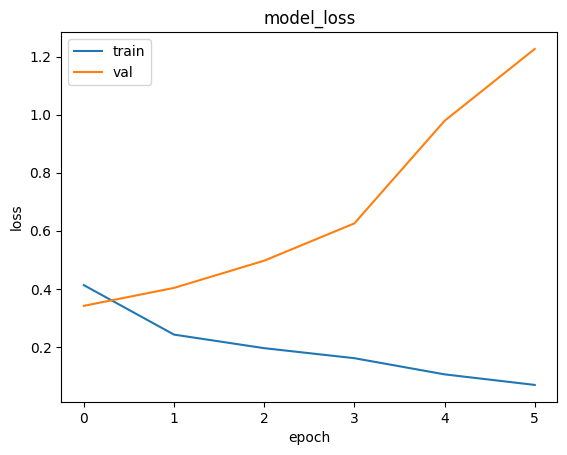

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

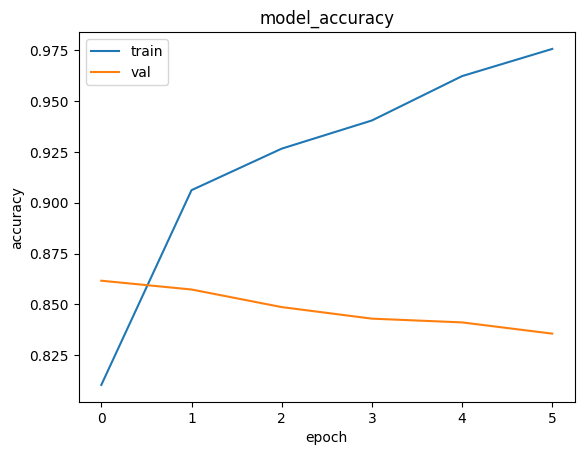

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [100]:
transformer.load_weights(checkpoint_filepath)

NameError: name 'checkpoint_filepath' is not defined

In [101]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
transformer.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8620 - loss: 0.3430


[0.3444173336029053, 0.8616799712181091]

In [102]:
# Get predictions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
)
import seaborn as sns


y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred_probs = transformer.predict(val_dataset).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate Metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))


196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
Precision: 0.8401
Recall: 0.8911
F1 Score: 0.8649

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.83      0.86      6291
     Class 1       0.84      0.89      0.86      6209

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [103]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")



AUC Score: 0.9374


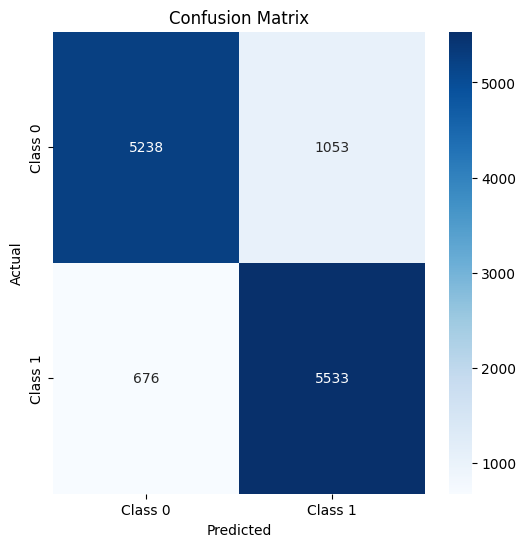

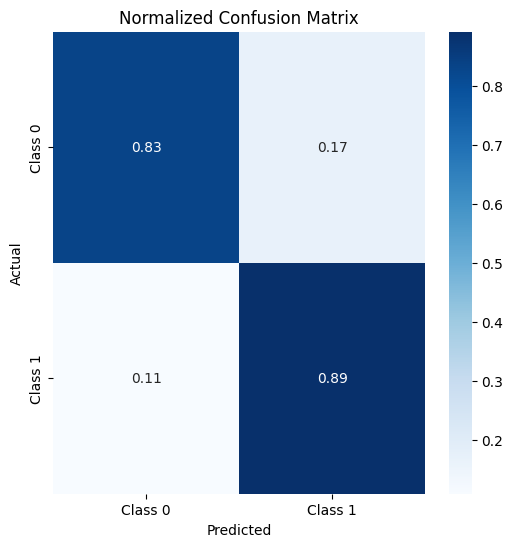

In [104]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
def plot_confusion_matrix(cm, title, labels, normalize=False):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm, "Confusion Matrix", labels=["Class 0", "Class 1"], normalize=False)
plot_confusion_matrix(cm_normalized, "Normalized Confusion Matrix", labels=["Class 0", "Class 1"], normalize=True)

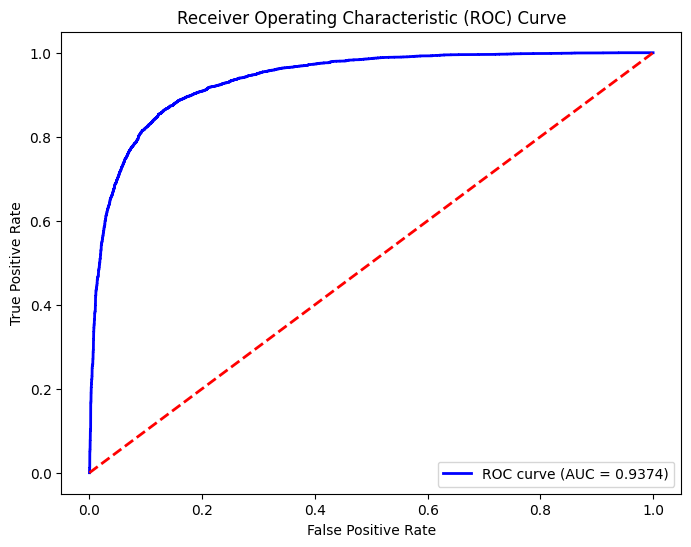

In [105]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [106]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])


In [107]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [108]:
transformer.predict(test_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[0.96243924],
       [0.38698217]], dtype=float32)

# LSH Attention

In [109]:
def look_one_back(x):
  x_extra=tf.concat([x[:,-1:,...],x[:,:-1,...]],axis=1)
  return tf.concat([x,x_extra],axis=2)

def sticker_look_one_back(x):
  x_extra=tf.concat([x[:-1:],x[:,:-1]],axis=1)
  return tf.concat([x,x_extra],axis=-1)

def causal_masker(a,b):
  a,b=tf.cast(a,dtype=tf.float32)+0.01,tf.cast(b,dtype=tf.float32)+0.01
  vals=tf.einsum('ipj,ipk->ipjk',b,1/a)
  out=tf.cast(tf.cast(tf.cast(vals,dtype=tf.int32),dtype=tf.bool),dtype=tf.int32)
  out=-out+1
  return tf.cast(out,dtype=tf.float32)

class LSHAttention(tf.keras.layers.Layer):
    def __init__(self,bucket_size=8,n_hashes=1):
        super(LSHAttention,self).__init__()
        self.n_hashes=n_hashes
        self.bucket_size=bucket_size

    def call(self,query,key,value,causal_masking=False):
        R=tf.random.normal((tf.shape(query)[0],tf.shape(query)[-1],self.bucket_size//2))
        xR=tf.matmul(query,R)
        concat_xR=tf.concat([xR,-xR],axis=-1)
        buckets=tf.math.argmax(concat_xR,axis=-1)

        sticker=tf.argsort(buckets)
        undo_sort=tf.argsort(sticker)
        sorted_query=tf.gather(query,sticker,axis=1,batch_dims=1)
        sorted_value=tf.gather(value,sticker,axis=1,batch_dims=1)

        chunked_query=tf.stack(tf.split(sorted_query,self.bucket_size,1),1)
        chunked_value=tf.stack(tf.split(sorted_value,self.bucket_size,1),1)

        sticker=tf.stack(tf.split(sticker,self.bucket_size,1),1)
        new_sticker=sticker_look_one_back(sticker)

        lb_chunked_query=look_one_back(chunked_query)
        lb_chunked_value=look_one_back(chunked_value)

        score=tf.einsum('bhie,bhje->bhij',chunked_query,lb_chunked_query)
        score/=tf.math.sqrt(tf.cast(query.shape[-1],tf.float32))

        if causal_masking==True:
            causal_mask=causal_masker(sticker,new_sticker)
            dots+=causal_mask*-1e-10
        score=tf.nn.softmax(score)
        output=tf.einsum('buij,buje->buie',score,lb_chunked_value)

        sorted_output=tf.reshape(output,(tf.shape(output)[0],tf.shape(query)[i],output.shape[3]))
        output=tf.gather(sorted_output,undo_sort,axis=1,batch_dims=1)
        return output